### Lighting Science Final Project  <br>
Takehiro Izumi, Amrit Shaw, Takuma Tsuruta <br>


# Preparation
First, import necesarry libraries for this project. 

In [5]:
from DMXEnttecPro import Controller
from DMXEnttecPro.utils import get_port_by_serial_number, get_port_by_product_id
import numpy as np
import time
from matplotlib import pyplot as plt
import datetime
import os
import luxpy as lx  # package for color science calculations
from luxpy.toolboxes import spectro as sp
import glob
from luxpy.toolboxes import spdbuild as spb

cieobs = '1964_10'

# Task 1
We implemented the `DMXHandler()` class for open/initialize, close and send values to DMX controller.<br>
In this class, there are three methods: `open`, `control_channels`, and `close`.<br>
First, pass the product id of DMX controller to initialize `DMXHandler()`. <br>
Then, use `open` to connect with DMX controller. Port id of DMX controller will be specified by `DMXEnttecPro.utils` from product id.<br>
`control_channels` will receive lists of driver values and list of channels which we want to turn on light, and turn on the lamp.<br>
`close` will trun off the lamp and disconnect from DMX controller.
 

In [6]:
class DMXHandler():
    def __init__(self, product_id: int) -> None:
        """
        product_id: int
        """
        self.product_id = product_id
        self.dmx = None
        self.is_connected = False
        self.all_channels = [0, 1, 2, 3, 4]

    def open(self):
        """
        try to connect with DMX
        """
        try:
            port = get_port_by_product_id(self.product_id)
            self.dmx = Controller(port)
            print('DMX connected')
            self.is_connected = True
        except:
            self.dmx = None
            print('no DMX connection')
            self.is_connected = False

    def control_channels(self, channels_idx: list=[0, 1, 2, 3, 4], dr_value_in: list=[0, 0, 0, 0, 0]):
        """
        channels_idx: length < 6
        dr_value_in: length < 6
        dr_value_in and channels_idx should have same length of list.
        channel 1,2,3,4,5,6 are the red, green, blue, warm white, amber, and UV channels respectively. 
        UV is default not selected defaultly.
        example: to turn on R 100, B 10
            dmx.control_channels(dr_value_in=[100, 10], channels_idx=[0, 1])
        """
        
        if len(channels_idx) != len(dr_value_in):
            print('Both input variables should have same length.')
        for c in self.all_channels:
            self.dmx.set_channel(c, 0)

        for (c, v) in zip(channels_idx, dr_value_in):
            self.dmx.set_channel(c+1, int(v))
        self.dmx.submit()

    def close(self):
        """
            Close DMX connection
        """
        if self.is_connected:
            self.dmx.set_channel(1, 0)
            self.dmx.submit()
            self.dmx.close()


Then, connect to the DMX controller using `DMXHandler()`.<br>
Product id can be confirmed by executing command `python -m DMXEnttecPro.utils`.

In [7]:
dmx = DMXHandler(24577)
dmx.open()

no DMX connection


Then, test some codes to make sure lamp is operated using `DMXHandler()`.

In [8]:
if dmx.is_connected:
    dmx.control_channels(channels_idx=[0, 1], dr_value_in=[100, 10])

# Task 2
First, initialize JETI spectroradiometers using `luxpy.toolboxes.spectro`.

In [9]:
sp.init('jeti')

To ensure successful measurement, check that the measurement point of the spectrometer is placed in the center of the irradiated target using laser light spot.

In [10]:
if dmx.is_connected:
    sp.jeti.set_laser(laser_on=True)
    dmx.control_channels(dr_value_in=[0, 0, 0, 0, 0])
    time.sleep(2)
    sp.jeti.set_laser(laser_on=False)

Three functions were created to measure light intensity using lamp and SPD.<br>
The `measureSPD` function executes `dmx.control_channels()` based on the input channel index and driver value, and returns the value obtained by SPD.<br>
`measureSPDforCalibration` is a function that turns on LEDs using `measureSPD` for each input channel index in the range specified by the driver value in succession, measures them with SPD, and returns a list of the measurement results.<br>
The `calibrate` function executes and saves SPD measurements using the `measureSPDforCalibration` function with driver values from 0 to 50 in increments of 5, and from 50 to 255 in increments of 10 for each color: red, green, blue, warm white, and amber. The smaller step size is taken for lower driver values beacuse, when target luminance is set to for example 100 $cd/m^2$, the driver values of each channel is very low and if higher steps are not taken it can cause error in the output. Also, at the very low driver values, the curve shows some irregularity. 

In [11]:

def measureSPD(channels_idx: list, dr_value_in: list):
    """
    channels_idx: length < 6
    dr_value_in: length < 6
    dr_value_in and channels_idx should have same length of list.
    turn on lamp and get spd from jeti
    """
    if not dmx.is_connected:
        return None
    # Avoid to measure with 0 output value because JETI can't be used in a dark room.
    if np.sum(dr_value_in) == 0:
        return None
    dmx.control_channels(channels_idx, dr_value_in)
    time.sleep(0.2)
    spd = sp.jeti.get_spd()
    return spd


def measureSPDforCalibration(channels_idx: list, dr_value_in):
    """
    channels_idx: length < 6
    dr_value_in: np.array, 0 < x < 256
    turn on lamp for all single channel of multiple driver value and get spd from jeti
    """
    measured_spd_all = []
    for channel in channels_idx:
        measured_spd = []
        for v in dr_value_in:
            print(channel, v)
            spd = measureSPD(channels_idx=[channel], dr_value_in=[v])
            measured_spd.append(spd)

        #  fill None data as zero spectrum
        if measured_spd[0] is None:
            measured_spd[0] = measured_spd[1].copy()
            measured_spd[0][-1] = measured_spd[0][-1]*0

        measured_spd = np.asarray(measured_spd)
        first_spd = measured_spd[0].copy()
        after_first_spd_intensity = measured_spd[1:, 1, :].copy()
        spd_channel = np.concatenate(
            [first_spd, after_first_spd_intensity], axis=0)
        measured_spd_all.append(spd_channel)
    return measured_spd_all


def calibrate(filename: str=None):
    # try to load existing calibration data when filename is specified.
    if filename is not None:
        return np.load(filename)

    if not dmx.is_connected:
        print('Connect DMX controller to run calibration.')
        return False

    now = datetime.datetime.now()
    filename = './output/data_' + now.strftime('%Y%m%d_%H%M%S')
    if not os.path.exists(os.path.dirname(filename)):
        os.mkdir(os.path.dirname(filename))

    channels = [0, 1, 2, 3, 4]
    dr_value_in = np.concatenate([np.arange(0, 50, 5), np.arange(50, 255, 10)])
    if dr_value_in[-1] < 255:  # make sure that the last value is max.
        dr_value_in = np.append(dr_value_in, 255)

    measured_spd_all = measureSPDforCalibration(channels, dr_value_in)
    np.savez(filename, spd=measured_spd_all,
             dr_value_in=dr_value_in, channels=channels)
    return np.load(filename+'.npz')


Then, use these functions to make measurements. <br>

In [12]:

# f = 'output/data_20230428_123213.npz'
f = 'data_20230502_162201_groupM.npz'
is_plot = True
data = calibrate(f)

dr_value = data['dr_value_in']
channels = data['channels']
measured_spd_all = data['spd']

labels = ['R', 'G', 'B', 'WH', 'A', 'UV']
print(channels)


[0 1 2 3 4 5]


After finishing measurements, calculate output-value v.s. output-luminance characteristic using poly fit function. <br>
This time, interpolation was performed using a 6-dimensional polynomial.<br>
The same six-dimensional polynomial was used to interpolate `normalized_luminance`, which was normalized to the luminance.<br>
The interpolated result and the spectrum are displayed as below.

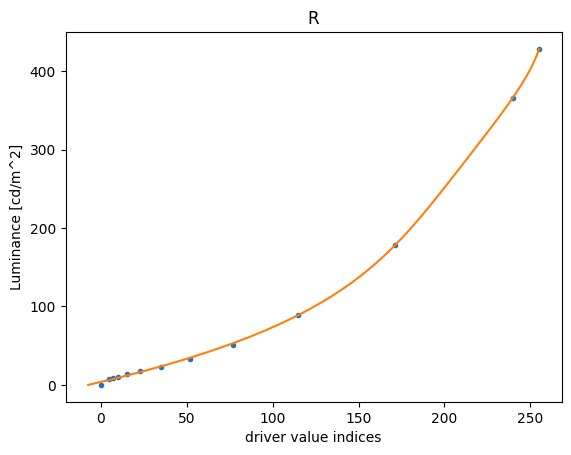

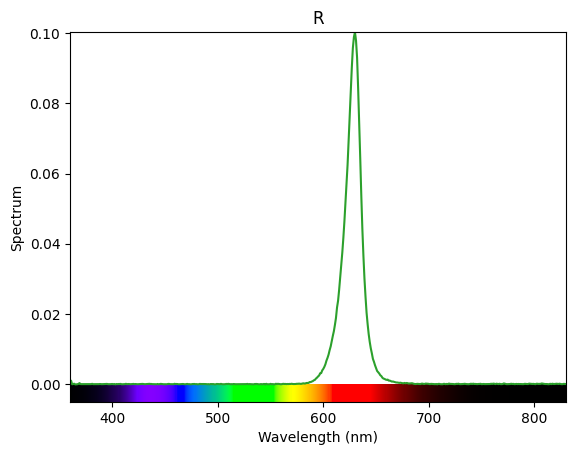

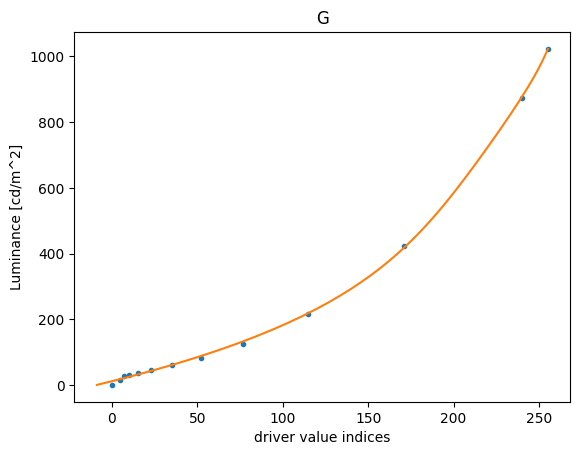

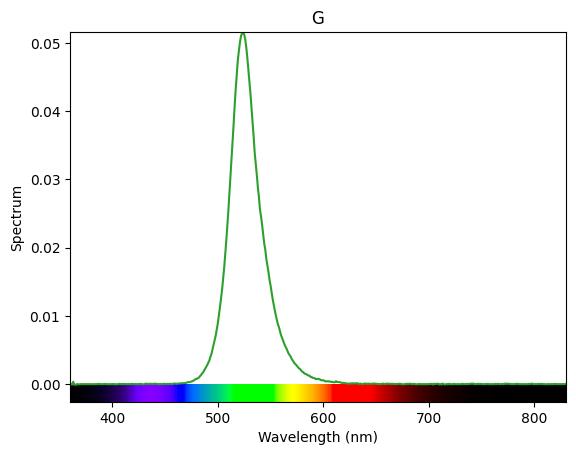

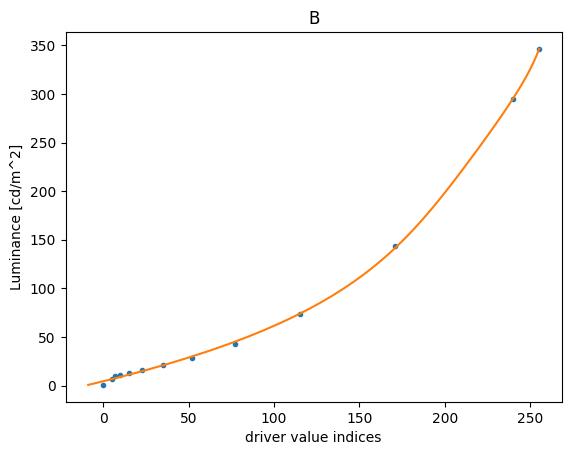

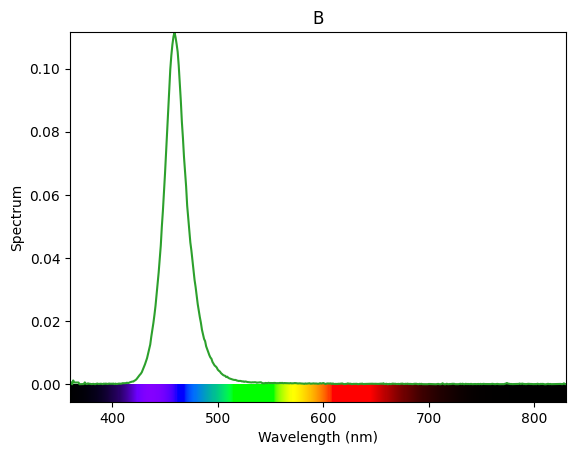

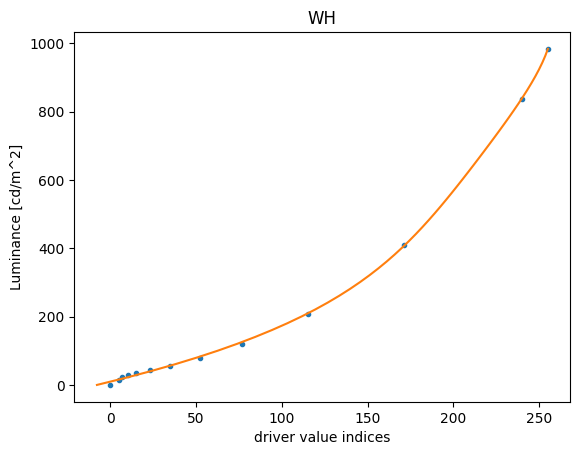

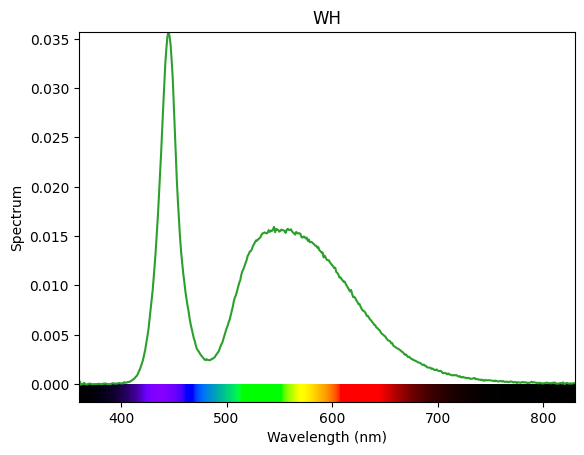

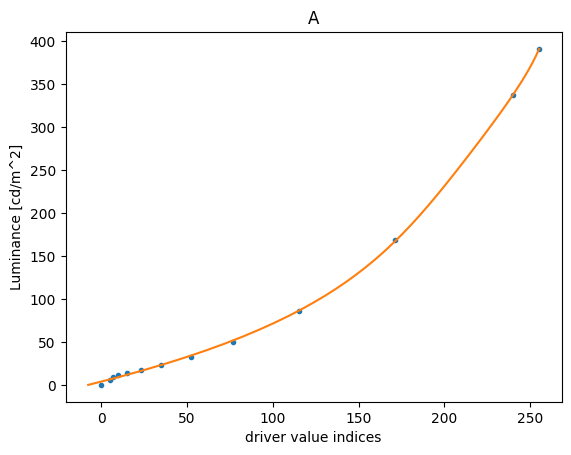

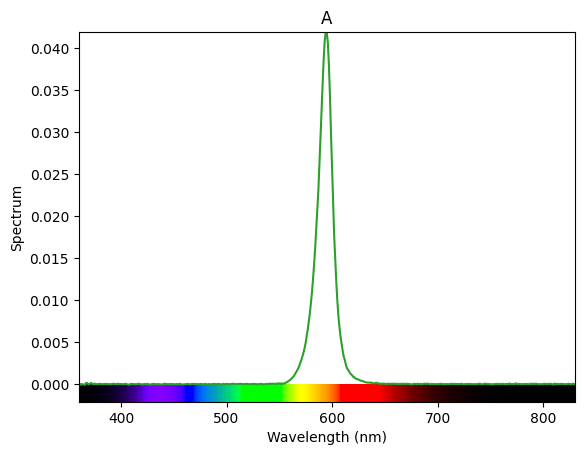

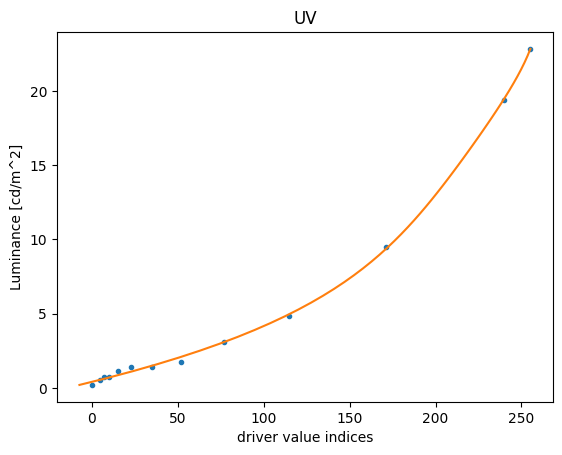

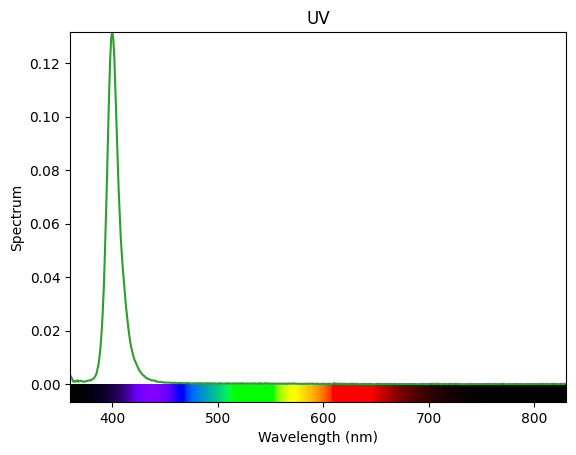

In [13]:
normL2drv = []
for i, channel in enumerate(channels):
    luminance = lx.spd_to_power(
        measured_spd_all[i], ptype='pu', cieobs=cieobs)[:, 0]
    normalized_luminance = luminance / max(luminance)
    # normalized_luminance = (luminance-min(luminance)) / (max(luminance)-min(luminance))

    z = np.polyfit(luminance, dr_value, 4)
    z_norm = np.polyfit(normalized_luminance, dr_value, 4)

    func = np.poly1d(z)
    func_norm = np.poly1d(z_norm)

    normL2drv.append(func_norm)    

    # for smooth ploting curve
    luminace_plot_steps = np.linspace(np.min(luminance), np.max(luminance), 50)
    normlumincance_plot_steps = np.linspace(0, 1, 50)
    if is_plot:
        plt.figure()
        plt.plot(dr_value, luminance, '.')
        plt.plot(func(luminace_plot_steps), luminace_plot_steps , '-')
        plt.xlabel('driver value indices')
        plt.ylabel('Luminance [cd/m^2]')
        plt.title(labels[i])
        plt.savefig('output/luminance_output_{}.png'.format(labels[i]))

        plt.figure()
        plt.plot(dr_value, normalized_luminance, '.')
        plt.plot(func_norm(normlumincance_plot_steps), normlumincance_plot_steps, '-')
        plt.xlabel('Output Value')
        plt.ylabel('Normalized Luminance')
        plt.title(labels[i])
        plt.savefig('output/normL_output_{}.png'.format(labels[i]))
        
        lx.SPD(np.vstack([measured_spd_all[i][0, :].copy(), measured_spd_all[i][-1, :].copy()])).plot()
        plt.title(labels[i])
        plt.savefig('output/spd_255_{}.png'.format(labels[i]))


# Task 3
The color mixing is performed by combining multiple channels of colors indicated by xyz(Yxy) chromaticity.<br>
The color mixing uses additive color mixing of the N primary colors using the Moore-Penrose pseudo-inverse matrix.<br>
The weights are applied to the function obtained by Polyfit and transformed.<br>
After that, if the driver is connected to dmx, measurement and evaluation are performed.<br>
In the evaluate stage, the input SPD values of the synthesized driver and the taerget xyz chromaticity are converted to the Luv color space, and the sum of squares error of uv is calculated.<br>

In [14]:
def getPrimarySPD(channels_idx):
    """
    Concat and return SPD results for channels specified by channels_idx
    """
    spd_p = []
    for c in channels_idx:
        spd = np.vstack((measured_spd_all[c, 0, :].copy(), measured_spd_all[c, -1, :].copy()))
        # spd[-1] = spd[-1] - measured_spd_all[c][0][-1]
        spd_p.append(spd)
    return np.vstack([spd_p[0][0]] +
                         [s[-1] for s in spd_p])

def getDriverValues(channels_idx, weights):
    """
    Retrieve and return the converted value of SPD with weights added to the function fitted by Polyfit
    """
    driver_values = []
    for i, w in zip(channels_idx, weights[0]):
        if w <= 0:
            driver_values.append(0)
            print("The weight was negative, so may not achieve accurate result.")
        elif w >= 1:
            driver_values.append(255)
        else:
            v = normL2drv[i](w)
            if v < 0:
                v = 0
            elif v > 255:
                v = 255
            driver_values.append(v)
    driver_values = np.around(driver_values)
    return np.asarray(driver_values, dtype = np.uint8)

def calculateOptimizedSPD(spd_p, weights):
    """
    Function to compute and return the value of SPD optimized by weights
    """
    weighted_p = spd_p[0:2].copy()
    weighted_p[-1] *= 0
    for (p, w) in zip(spd_p[1:], weights[0]):
        weighted_p[-1] += p*w
    return weighted_p

def showMixedSPD(spd_p, spd_optimized): 
    """
    Plot each SPD before mix and target SPD after mix
    memo: weighted_p is the optimized spd and spd_p is the primary stacked spd
    """
    fig,ax = plt.subplots(1,2, figsize=(18,6))
    plt.sca(ax[0]); 
    plt.title('Primaries')
    lx.SPD(spd_p).plot()
    plt.sca(ax[1]); 
    plt.title('Mixed SPD for the target')
    lx.SPD(spd_optimized).plot()

def evaluate(spd, xyz_t):
    """
    Receive xyz chromaticity of SPD and target, compare and plot xyz chromaticity, 
    CCT, and CRI calculated from Luminance and SPD.
    """
    l = lx.spd_to_power(spd, ptype='pu', cieobs=cieobs)
        
    xyz_obtained = lx.spd_to_xyz(spd, relative=False, cieobs=cieobs)
    print("Luminance [cd/m2] : {:1.1f}".format(l[0][0]))
    
    print("xyz : [ {0[0]:1.1f}, {0[1]:1.1f}, {0[2]:1.1f} ]".format(xyz_obtained[0]))
    print("Target xyz : [ {0[0]:1.1f}, {0[1]:1.1f}, {0[2]:1.1f} ]".format(xyz_t[0]))
    
    # print((lx.xyz_to_cct(xyz_obtained, cieobs=cieobs, out='cct'))[0])

    cct, duv = lx.xyz_to_cct(xyz_obtained, cieobs=cieobs, out='cct,duv')
    Rf, Rg = lx.cri.spd_to_cri(spd, cri_type='ies-tm30', out='Rf,Rg')

    print("CCT: {:1.1f}".format(cct[0][0]))
    print("Duv: {:1.5f}".format(duv[0][0]))
    
    print("Rf: {:1.1f}".format(Rf[0][0]))
    print("Rg: {:1.1f}".format(Rg[0][0]))
    print("LER: {:1.1f}".format((lx.spd_to_ler(spd))[0,0]))

    get_color_difference(spd,xyz_t)


    Yuv_obtained = lx.xyz_to_Yuv(xyz_obtained)
    Yuv_target = lx.xyz_to_Yuv(xyz_t)


    
    Y_t, u_t, v_t = lx.utils.asplit(Yuv_target)
    Y, u, v = lx.utils.asplit(Yuv_obtained)
    
    fig, ax = plt.subplots(1,2,figsize=(18,6))


    ax[0].plot(u, v,
            color ='r', marker = 'o', linestyle = 'none', label='obtained')
    ax[0].plot(u_t, v_t,
            color ='b', marker ='d', linestyle = 'none', label='target')
    ax[0].set_xlabel("u'")  # set x-axis label
    ax[0].legend()
    ax[0].set_ylabel("v'")  # set y-axis label
    
    lx.cri.plot_tm30_cvg(spd, axh=ax[1]) # maybe this is not using cieobs=1964_10, so the cct value could be different.

    lx.plotSL(cieobs=cieobs, cspace='Yuv', DL=False,
        BBL=True, diagram_colors=True, axh=ax[0])

def get_color_difference(spd, xyz_t):
    """
    to get the color difference and JNDs from the target and obtained spectrum. Deals with Yuv, Luv and Lab color spaces. 
    """
    xyz_obtained = lx.spd_to_xyz(spd, relative=False, cieobs=cieobs)
    
    luv_obt = lx.xyz_to_luv(xyz_obtained)
    luv_tar = lx.xyz_to_luv(xyz_t)

    lab_obt = lx.xyz_to_lab(xyz_obtained)
    lab_tar = lx.xyz_to_lab(xyz_t)

    Yuv_obt = lx.xyz_to_Yuv(xyz_obtained, cieobs=cieobs)
    Yuv_tar = lx.xyz_to_Yuv(xyz_t, cieobs=cieobs)

    # Calculate L*u*v* and L*a*b* color difference manually:

    DEuv_luv = np.sqrt((luv_tar[0,0] - luv_obt[0,0])**2 + (luv_tar[0,1] - luv_obt[0,1])**2 + (luv_tar[0,2] - luv_obt[0,2])**2 )

    DEab_lab = np.sqrt((lab_tar[0,0] - lab_obt[0,0])**2 + (lab_tar[0,1] - lab_obt[0,1])**2 + (lab_tar[0,2] - lab_obt[0,2])**2)

    DEuv_uv = np.sqrt((Yuv_tar[0,1] - Yuv_obt[0,1])**2 + (Yuv_tar[0,2] - Yuv_obt[0,2])**2 )

    
    
    print('Obtained Lu*v*: {0[0]:1.4f}, {0[1]:1.4f}, {0[2]:1.4f}'.format(luv_obt[0]))
    print('Target Lu*v*: {0[0]:1.4f}, {0[1]:1.4f}, {0[2]:1.4f}'.format(luv_tar[0]))

    print('Obtained u\': {:1.4f}'.format(Yuv_obt[0,1]))
    print('Target u\': {:1.4f}'.format(Yuv_tar[0, 1]))
    print('Obtained v\': {:1.4f}'.format(Yuv_obt[0, 2]))
    print('Target v\': {:1.4f}'.format(Yuv_tar[0,2]))

    print("color difference in LUV space: {:1.3f}".format(DEuv_luv))
    print("color difference in Lab space: {:1.3f}".format(DEab_lab))

    # print("color difference in UV space: {:1.3f}".format(DEuv_uv))
    if DEuv_uv < 0.001:
        print("JND in u\'v\' chromaticity:",0)
    else:
        jnd = int(np.ceil(DEuv_uv/0.006))
        print("JNDs in u\'v\' chromaticity:", jnd)

    # print("color difference in UV space: {:1.3f}".format(DEuv_uv))
    print("JNDs in u\'v\' chromaticity based on CIELAB:{0:1.4f}".format(DEab_lab))
  
  

def color_mixing(xyz_t, channels_idx):
    """
    Find driver_values using additive color mixing of N primary colors with 
    Moore-Penrose pseudo-inverse matrix, then execute the previous functions and compare them.
    Then, if connected to dmx, actually measure and evaluate.
    """
    Yxy_t = lx.xyz_to_Yxy(xyz_t)
    spd_p = getPrimarySPD(channels_idx=channels_idx)
    xyz_p = lx.spd_to_xyz(spd_p, relative=False, cieobs=cieobs) # always mention CIE when convert spd to colorimetric value
    Yxy_p = lx.xyz_to_Yxy(xyz_p)
    
    M_xyz = spb.colormixer_pinv(xyz_t, xyz_p, input_fmt='xyz') 
    # M_Yxy = spb.colormixer_pinv(Yxy_t, Yxy_p, input_fmt='Yxy') 
    M = M_xyz
    driver_values = getDriverValues(channels_idx, M)

    print('Selected channels:', [labels[c] for c in channels_idx])
    print('Optimized primary contributions:', M[0])
    print('driver values of the light source:', driver_values)
    

    print('\n-----------Optimized------------')
    spd_optimized = calculateOptimizedSPD(spd_p, M)
    showMixedSPD(spd_p, spd_optimized)
    evaluate(spd_optimized, xyz_t)
    
    if dmx.is_connected:
        print('\n------------Measured------------')
        spd_measured = measureSPD(channels_idx, driver_values)
        showMixedSPD(spd_p, spd_measured)
        evaluate(spd_measured, xyz_t)

    return spd_optimized


### 3-channels colormixing
The result of the 3-channel color mixing is as follows

Selected channels: ['R', 'G', 'B']
Optimized primary contributions: [6.9037e-02 5.9205e-02 2.8532e-02]
driver values of the light source: [44 35 12]

-----------Optimized------------
Luminance [cd/m2] : 100.0
xyz : [ 100.0, 100.0, 100.0 ]
Target xyz : [ 100.0, 100.0, 100.0 ]
CCT: 5482.0
Duv: -0.00414
Rf: 60.8
Rg: 122.4
LER: 269.2
Obtained Lu*v*: 100.0000, 16.4922, 6.9522
Target Lu*v*: 100.0000, 16.4922, 6.9522
Obtained u': 0.2105
Target u': 0.2105
Obtained v': 0.4737
Target v': 0.4737
color difference in LUV space: 0.000
color difference in Lab space: 0.000
JND in u'v' chromaticity: 0
JNDs in u'v' chromaticity based on CIELAB:0.0000


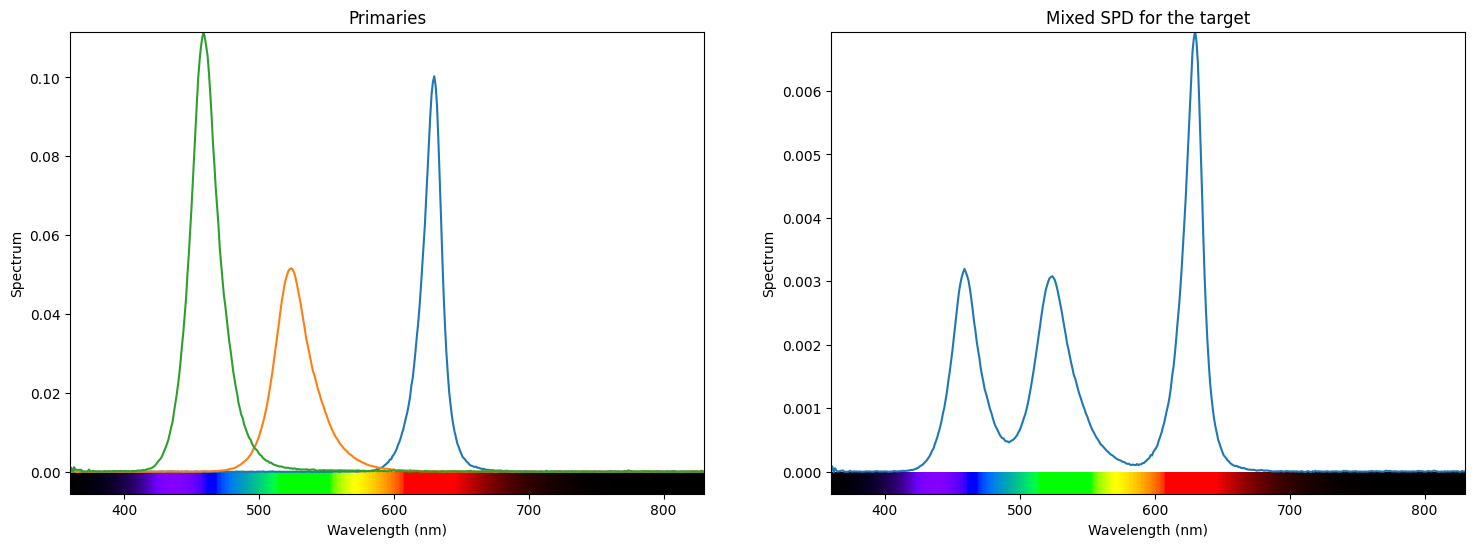

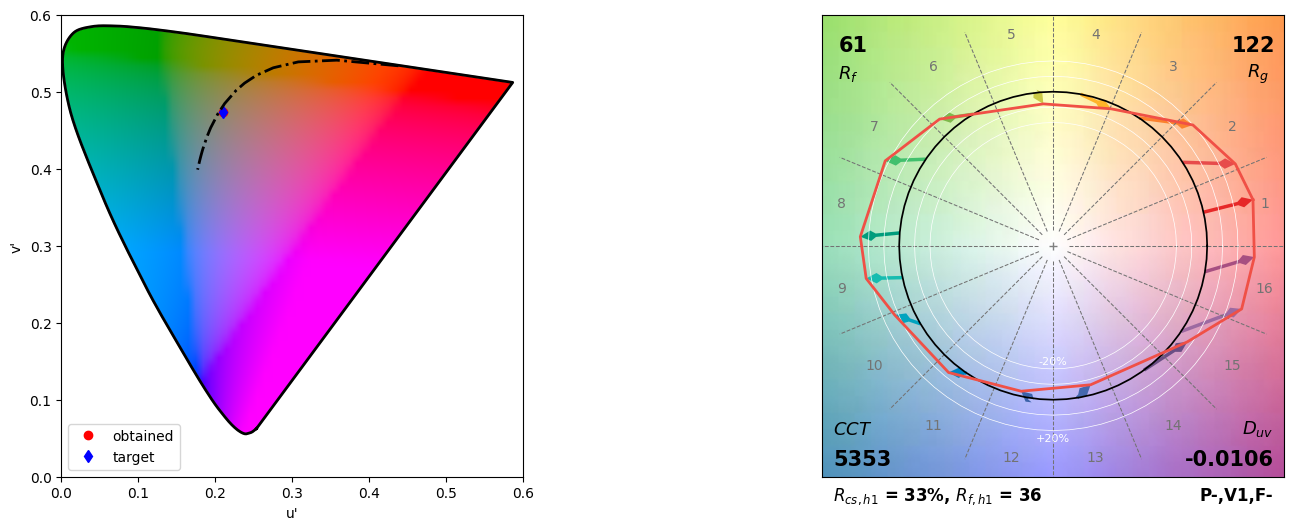

In [15]:
xyz_t = np.array([[100, 100, 100]])*1
channels_idx = [0, 1, 2]
spd3 = color_mixing(xyz_t, channels_idx)

### 4-channels colormixing
The result of the 4-channel color mixing is as follows

Selected channels: ['R', 'G', 'B', 'A']
Optimized primary contributions: [4.8698e-02 5.4102e-02 2.8661e-02 3.5536e-02]
driver values of the light source: [31 31 12 18]

-----------Optimized------------
Luminance [cd/m2] : 100.0
xyz : [ 100.0, 100.0, 100.0 ]
Target xyz : [ 100.0, 100.0, 100.0 ]
CCT: 5482.0
Duv: -0.00414
Rf: 74.3
Rg: 114.6
LER: 288.4
Obtained Lu*v*: 100.0000, 16.4922, 6.9522
Target Lu*v*: 100.0000, 16.4922, 6.9522
Obtained u': 0.2105
Target u': 0.2105
Obtained v': 0.4737
Target v': 0.4737
color difference in LUV space: 0.000
color difference in Lab space: 0.000
JND in u'v' chromaticity: 0
JNDs in u'v' chromaticity based on CIELAB:0.0000


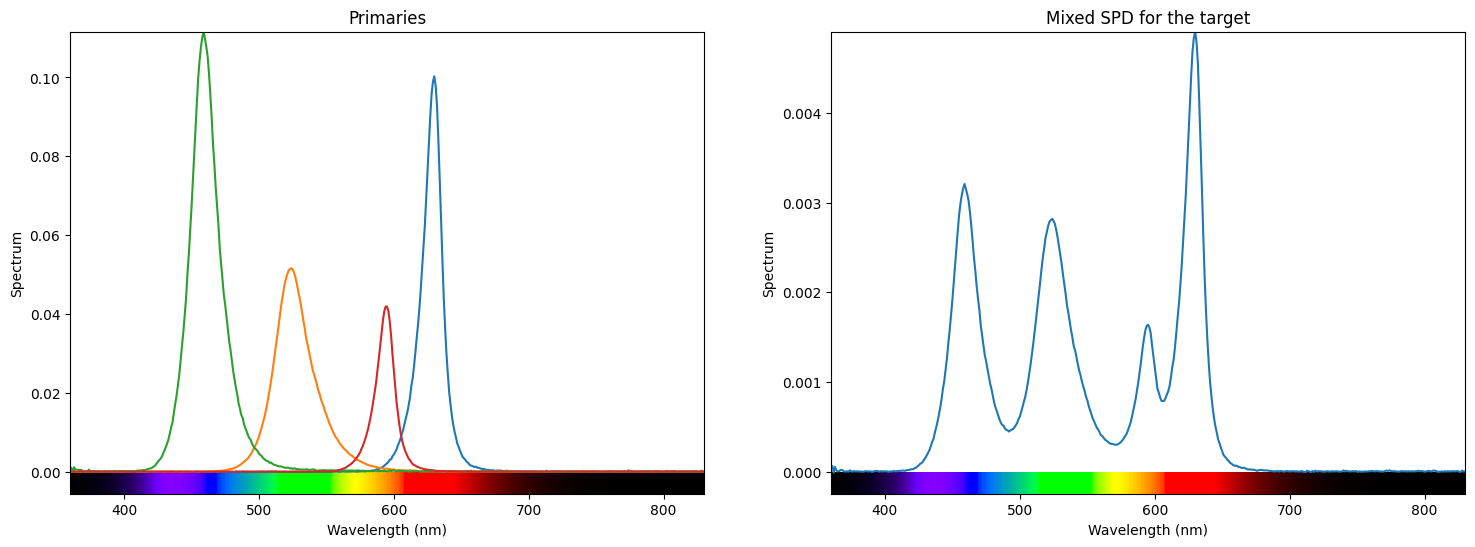

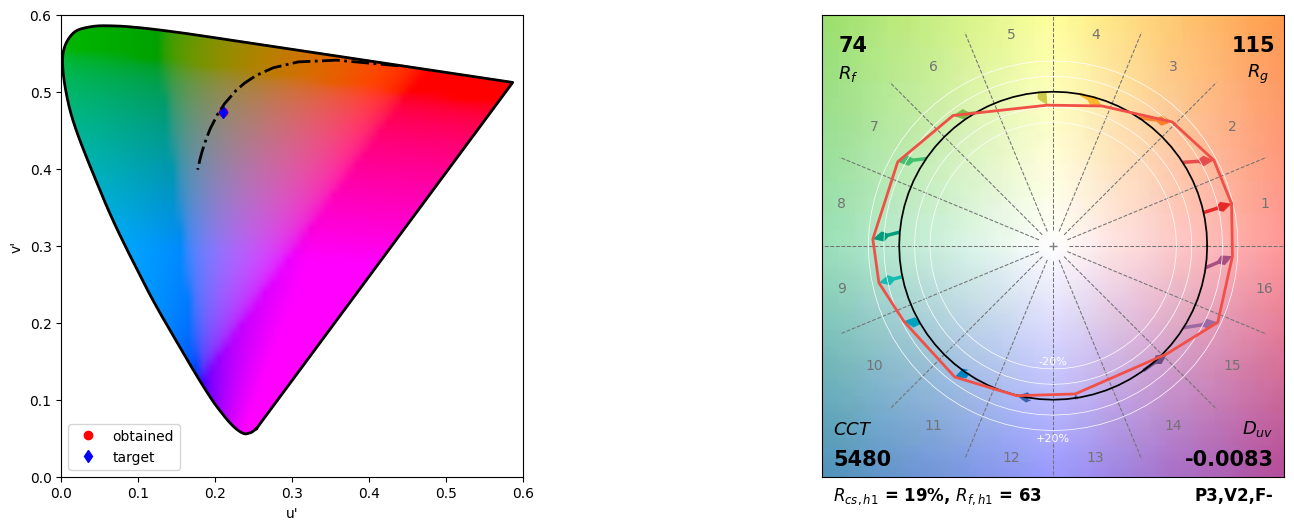

In [16]:
xyz_t = np.array([[100, 100, 100]])*1
channels_idx = [0, 1, 2, 4]
spd4 = color_mixing(xyz_t,  channels_idx)

### 5-channels colormixing
The result of the 5-channel color mixing is as follows

Selected channels: ['R', 'G', 'B', 'WH', 'A']
Optimized primary contributions: [2.8978e-02 3.1711e-02 1.5334e-02 4.2315e-02 2.1083e-02]
driver values of the light source: [16 16  2 24  7]

-----------Optimized------------
Luminance [cd/m2] : 100.0
xyz : [ 100.0, 100.0, 100.0 ]
Target xyz : [ 100.0, 100.0, 100.0 ]
CCT: 5482.0
Duv: -0.00414
Rf: 87.9
Rg: 110.8
LER: 305.1
Obtained Lu*v*: 100.0000, 16.4922, 6.9522
Target Lu*v*: 100.0000, 16.4922, 6.9522
Obtained u': 0.2105
Target u': 0.2105
Obtained v': 0.4737
Target v': 0.4737
color difference in LUV space: 0.000
color difference in Lab space: 0.000
JND in u'v' chromaticity: 0
JNDs in u'v' chromaticity based on CIELAB:0.0000


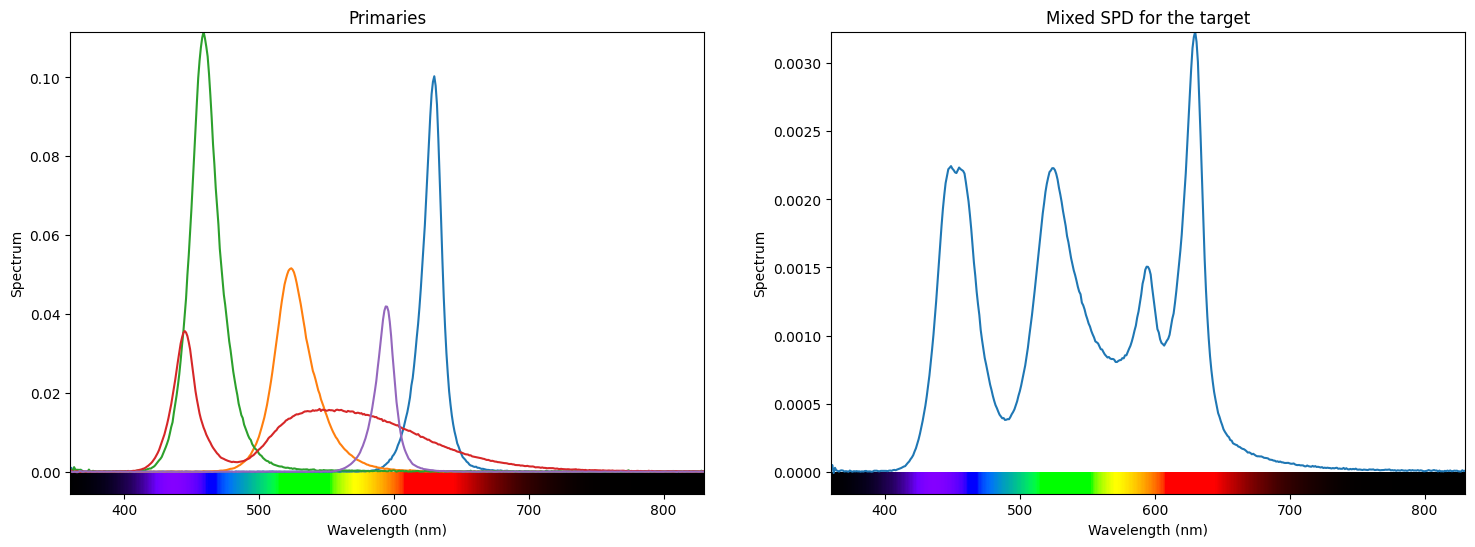

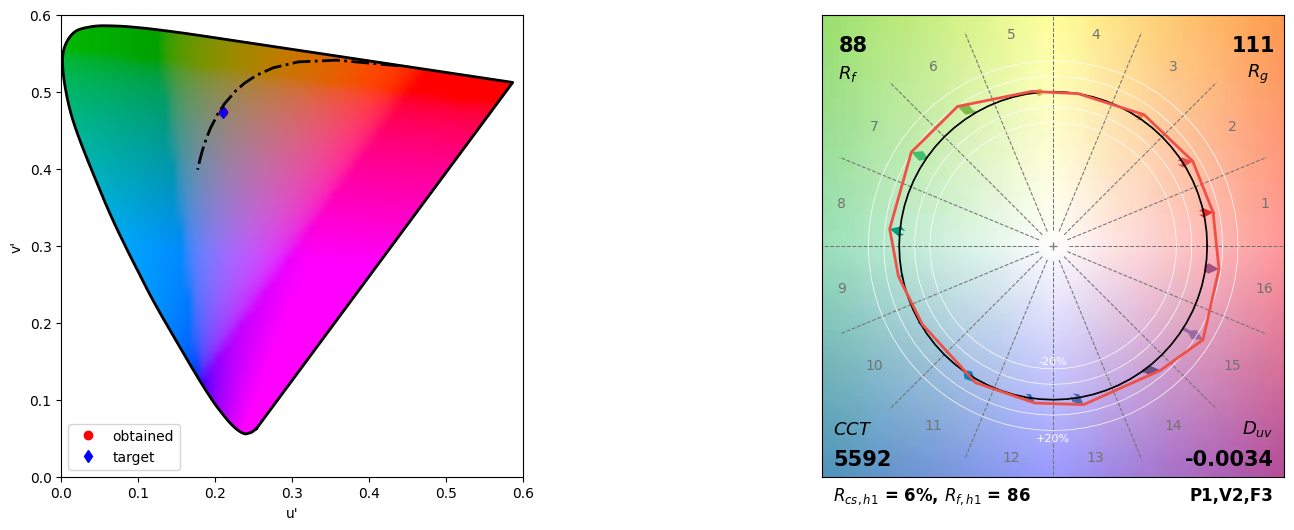

In [17]:
xyz_t = np.array([[100, 100, 100]])*1
channels_idx = [0, 1, 2, 3, 4]
spd5 = color_mixing(xyz_t,  channels_idx)

Manually 3 channel and n channel color mixing:

In [18]:

p = np.array([[110,180,150], [120,200,130], [150,150,110]])
ct = [100,100,100]

def man_color_mixing(p,ct):
   Cp = p.T
   Ct = np.asarray(ct)
   if Cp.shape == (3,3):
      return np.linalg.inv(Cp)@Ct
   else:
      return (Cp.T@np.linalg.inv(Cp@Cp.T))@Ct
   
w = man_color_mixing(p, ct)
print("weigths are:", w)
print("testing results: target X,Y,Z obtained is ",w.T@p)


weigths are: [8.1841e-01 -7.1611e-01 6.3939e-01]
testing results: target X,Y,Z obtained is  [1.0000e+02 1.0000e+02 1.0000e+02]


# TASK 4


### Multi-objective optimizer
Use `SpectralOptimizer()` in `luxpy.toolboxes.spdbuild` for spectral optimization.<br>
We can choose from three optimization options `Nelder-Mead`, `particleswarm` and `demo` as the method of spectralOptimizationMinimizer.<br>
The optimization is performed by specifying the target types and converting them to xyz chromaticity.<br>
For optimization, `spb.SpectralOptimizer()` is used and `spd_to_cris` and `spd_to_LER` are defined as functions to use Rf, Rg and LER for optimization as `spb.ObjFcn`.<br>
The optimization results are then compared based on the optimized SPD and weight, and if dmx is connected, the actual values are measured and then compared and evaluated again.<br>

In [19]:
def spectralOptimization(channels_idx, target=None, tar_type='xyz', Rf_Rg=None, LER=None, method='Nelder-Mead'):
        
    methods = ['Nelder-Mead', 'particleswarm', 'demo']
    if method not in methods:
        print('Specify correct method.', methods)
        return 

    tar_types = ["xyz_t, Yxy_t, cct_t"]    
    if tar_type == 'xyz':
        xyz_t = target # for the evaluation process
    elif tar_type =='Yxy':
        
        xyz_t = lx.Yxy_to_xyz(target) # for the evaluation process
    elif tar_type == 'cct':
        
        xyz_t = lx.cct_to_xyz(target) # for the evaluation process
    else:
        print('Specify correct target type.', tar_types)
        return 

    # define function that calculates several objectives at the same time (for speed):
    def spd_to_cris(spd):
        Rf, Rg = lx.cri.spd_to_cri(spd, cri_type='ies-tm30', out='Rf,Rg')
        return np.vstack((Rf, Rg))

    def spd_to_LER(spd):
        LER = lx.spd_to_ler(spd, cieobs=cieobs)
        return LER.T
    
    obj_fcn = []
    obj_tar_vals = []
    if Rf_Rg is not None:
        obj_fcn.append((spd_to_cris, 'Rf', 'Rg'))
        obj_tar_vals.append(Rf_Rg) 
    if LER is not None:
        obj_fcn.append((spd_to_LER, 'LER'))
        obj_tar_vals.append(LER) 

    spd_p = getPrimarySPD(channels_idx=channels_idx)
    so = spb.SpectralOptimizer(target = target,
                                tar_type = tar_type,
                                wlr = [360,830,1], 
                                cieobs = cieobs, 
                                out = 'spds,primss,Ms,results',
                                optimizer_type = '3mixer',
                                prim_constructor = None, 
                                prims = spd_p,
                                obj_fcn = spb.ObjFcns(f = obj_fcn,
                                                    ft = obj_tar_vals),
                                                    # fw = obj_fcn_weights),
                                minimizer = spb.Minimizer(method=method),
                                verbosity = 0)

    # start optimization:
    start_time = time.time()
    S, M = so.start(out='spds,Ms')
    print('Running time for the optimization: {:.2f} sec'.format(time.time()-start_time))

    driver_values = getDriverValues(channels_idx, M)
    print('Optimized primary contributions:', M[0])
    print('driver values values of the light source:', driver_values)

    def _result(spd):
        xyz = lx.spd_to_xyz(spd, relative=False, cieobs=cieobs)
        Yxy = lx.xyz_to_Yxy(xyz)
        cct, duv = lx.xyz_to_cct(xyz, cieobs=cieobs, out='cct,duv')
        Rf, Rg = spd_to_cris(spd)
        res_LER = spd_to_LER(spd)

        # _cct, _duv = lx.colortf(spd, tf = 'spd>cct', 
        #                  bwtf = {'cieobs':cieobs}, 
        #                  fwtf = {'cieobs':cieobs, 'out':'cct,duv'}) # note that this is the same as a call to spd_to_xyz followed by a coll to xyz_to_cct

        print('Results (optim,target):')
        print("Rf: ({:1.2f}, {:1.2f})".format(Rf[0], np.nan if Rf_Rg is None else Rf_Rg[0]))
        print("Rg: ({:1.2f}, {:1.2f})".format(Rg[0], np.nan if Rf_Rg is None else Rf_Rg[1]))
        print("CCT [K]: ({:1.1f}, {:1.1f})".format(cct[0][0], np.nan if tar_type != 'cct' else target[0][0]))
        print("Duv: ({:1.4f}, {:1.4f})".format(duv[0][0], np.nan if tar_type != 'cct' else target[0][-1]))

        print("LER [lm/W]: ({:1.1f}, {:1.1f})".format(res_LER[0][0], np.nan if LER is None else LER))
    
    print('\n------Optimized Result-------')
    _result(S)
    showMixedSPD(spd_p, S)
    evaluate(S, xyz_t)
    
    if dmx.is_connected:
        print('\n------Measured Result-------')
        spd_measured = measureSPD(channels_idx, driver_values)
        _result(spd_measured)
        showMixedSPD(spd_p, spd_measured)
        evaluate(spd_measured, xyz_t)

Then the result of target xyz tristimulus values and cct are shown below.

Running time for the optimization: 1.51 sec
Optimized primary contributions: [6.3461e-03 3.8176e-02 5.3378e-02 1.7257e-02 5.8311e-02]
driver values values of the light source: [ 0 20 30  6 33]

------Optimized Result-------
Results (optim,target):
Rf: (78.74, 80.00)
Rg: (91.42, 95.00)
CCT [K]: (31724.0, nan)
Duv: (-0.0023, nan)
LER [lm/W]: (286.4, 350.0)
Luminance [cd/m2] : 100.0
xyz : [ 100.0, 100.0, 200.0 ]
Target xyz : [ 100.0, 100.0, 200.0 ]
CCT: 31724.0
Duv: -0.00225
Rf: 78.7
Rg: 91.4
LER: 251.0
Obtained Lu*v*: 100.0000, -20.8283, -77.0191
Target Lu*v*: 100.0000, -20.8283, -77.0191
Obtained u': 0.1818
Target u': 0.1818
Obtained v': 0.4091
Target v': 0.4091
color difference in LUV space: 0.000
color difference in Lab space: 0.000
JND in u'v' chromaticity: 0
JNDs in u'v' chromaticity based on CIELAB:0.0000


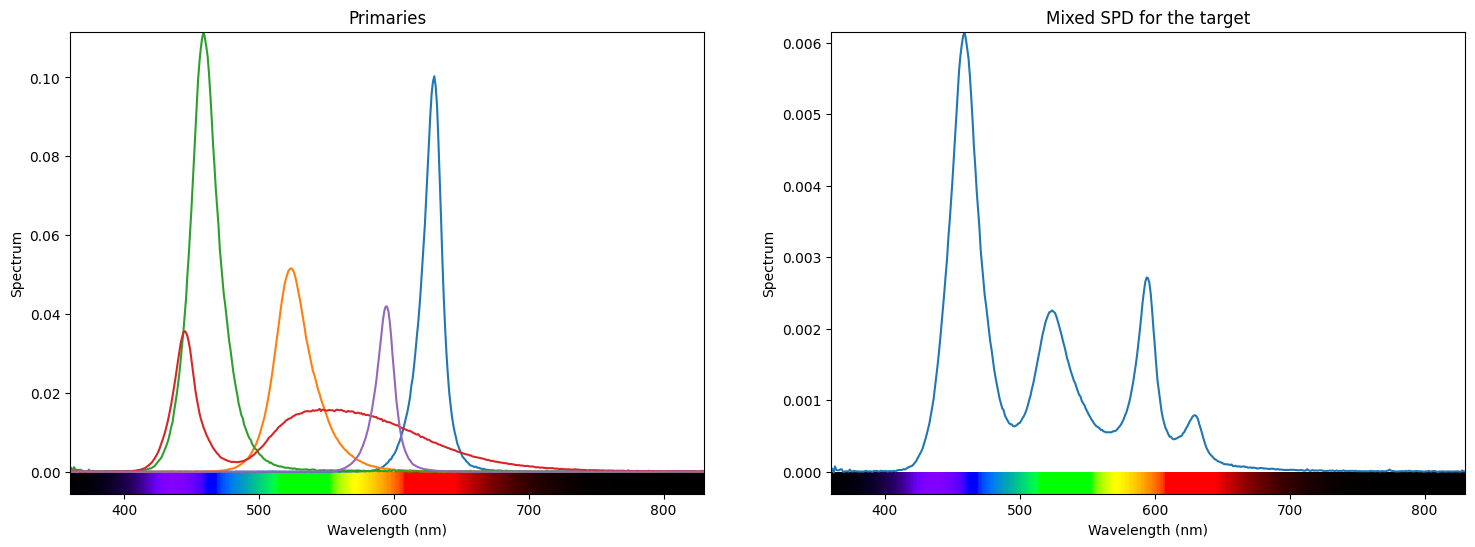

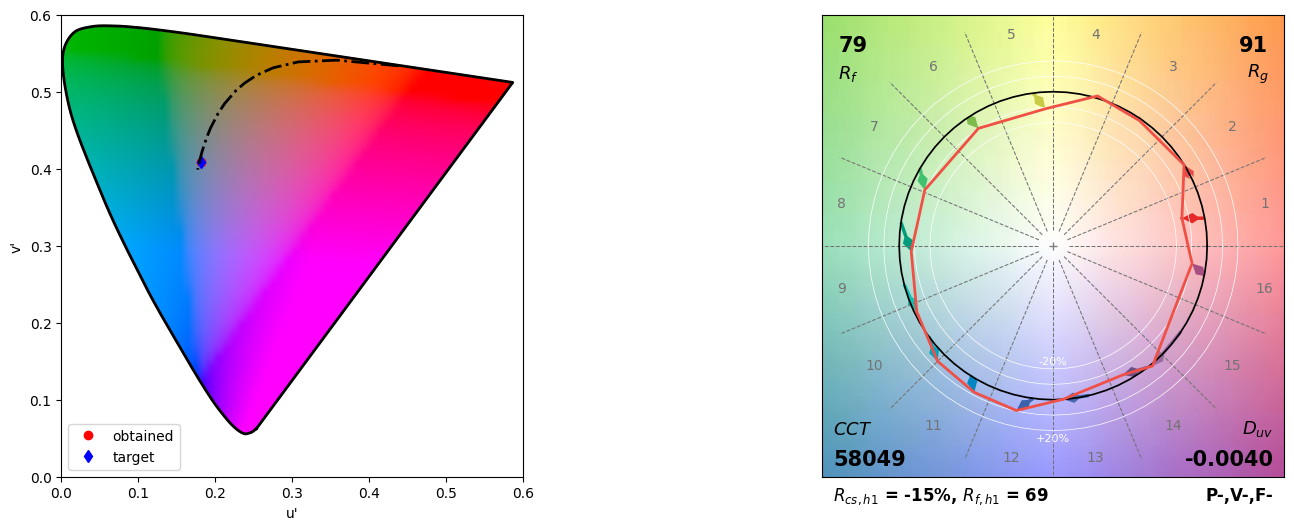

Running time for the optimization: 1.62 sec
Optimized primary contributions: [1.3387e-02 1.9824e-02 1.9374e-03 5.5169e-02 4.8817e-02]
driver values values of the light source: [ 4  7  0 33 27]

------Optimized Result-------
Results (optim,target):
Rf: (80.29, 80.00)
Rg: (99.33, 95.00)
CCT [K]: (4065.1, 4000.0)
Duv: (-0.0020, -0.0030)
LER [lm/W]: (375.7, 350.0)
Luminance [cd/m2] : 100.0
xyz : [ 102.5, 100.0, 68.4 ]
Target xyz : [ 102.5, 100.0, 68.4 ]
CCT: 4065.1
Duv: -0.00199
Rf: 80.3
Rg: 99.3
LER: 355.1
Obtained Lu*v*: 100.0000, 37.6646, 38.4010
Target Lu*v*: 100.0000, 37.6646, 38.4010
Obtained u': 0.2268
Target u': 0.2268
Obtained v': 0.4979
Target v': 0.4979
color difference in LUV space: 0.000
color difference in Lab space: 0.000
JND in u'v' chromaticity: 0
JNDs in u'v' chromaticity based on CIELAB:0.0000


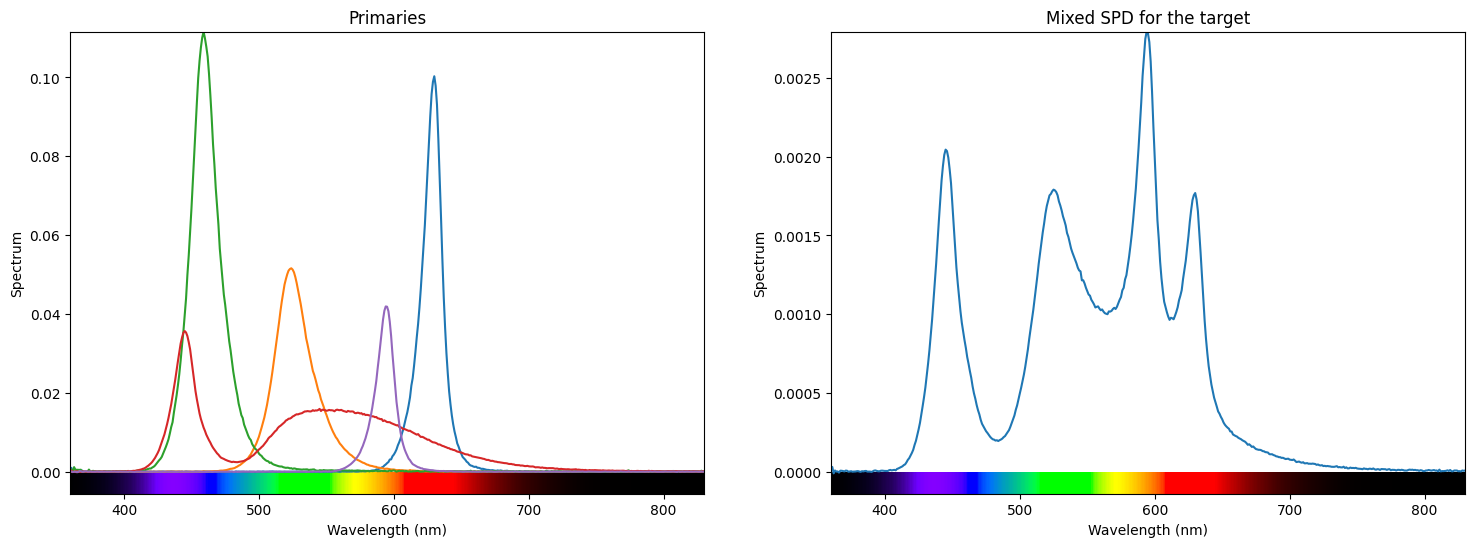

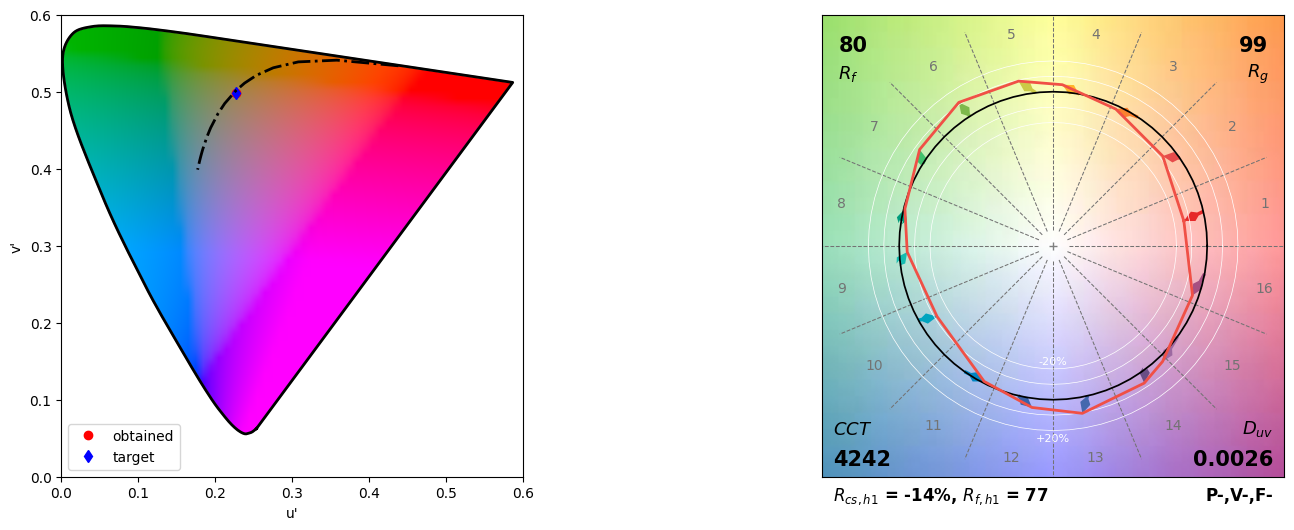

In [20]:
xyz_t = np.array([[100, 100, 200]])
Yxy_t = np.array([[100,1/3,1/3]])
cct_t = np.array([[4000, -0.003]])
channels_idx = [0, 1, 2, 3, 4]

spectralOptimization(channels_idx, target=xyz_t, tar_type='xyz',Rf_Rg=(80, 95), LER=350, method='particleswarm')
spectralOptimization(channels_idx, target=cct_t, tar_type='cct',Rf_Rg=(80, 95), LER=350, method='particleswarm')


In [21]:
dmx.close()